In [2]:
"""
Title: Prediction of rare events flood 2017 Goslar, Germany
Institute for Software and Systems Engineering (Technische Universität Clausthal)

Authors: Dimitri Bratzel M.Sc., Abhishek Buragohain M.Sc.
Review: Prof. Dr. Andreas Rausch, Dr. Steffan Wittek

Created on:

"""
# %% includes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import csv
from datetime import datetime
import tensorflow as tf
from pandas import DataFrame
import keras
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
import joblib


### read the data

In [3]:
df = pd.read_csv("data/input.csv",
                     delimiter=";", 
                     index_col="date_time")
df = df.rename(columns={"granetalsperre_rainfall": "Granetalsperre [l/m²]",
                            "hahnenklee_rainfall": "Hahnenklee [l/m²]",
                            "margarethenklippe_level": "Margarethenklippe [cm]",
                            "margarethenklippe_current": "Margarethenklippe [m³/s]",
                            "sennhuette_level": "Sennhuette [cm]",
                            "sennhuette_current": "Sennhuette [m³/s]"}, 
                   inplace=False)

In [4]:
df.columns

Index(['Granetalsperre [l/m²]', 'Hahnenklee [l/m²]', 'Margarethenklippe [cm]',
       'Margarethenklippe [m³/s]', 'Sennhuette [cm]', 'Sennhuette [m³/s]'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 514176 entries, 2003-01-11 00:15:00 to 2018-06-30 00:00:00
Data columns (total 6 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Granetalsperre [l/m²]     514176 non-null  float64
 1   Hahnenklee [l/m²]         514176 non-null  float64
 2   Margarethenklippe [cm]    514176 non-null  float64
 3   Margarethenklippe [m³/s]  514176 non-null  float64
 4   Sennhuette [cm]           514176 non-null  float64
 5   Sennhuette [m³/s]         514176 non-null  float64
dtypes: float64(6)
memory usage: 27.5+ MB


In [7]:
df.describe()


Granetalsperre [l/m²]  Hahnenklee [l/m²]  Margarethenklippe [cm]  \
count          514176.000000      514176.000000           514176.000000   
mean                0.026348           0.037620               10.395733   
std                 0.189033           0.213194                5.839140   
min                 0.000000           0.000000                3.700000   
25%                 0.000000           0.000000                6.600000   
50%                 0.000000           0.000000                8.700000   
75%                 0.000000           0.000000               12.100000   
max                25.400000          24.500000              160.600000   

       Margarethenklippe [m³/s]  Sennhuette [cm]  Sennhuette [m³/s]  
count             514176.000000    514176.000000      514176.000000  
mean                   0.123177         7.975649           0.108156  
std                    0.202967         6.261150           0.199293  
min                    0.009000         1.500000           0.005000  
25%                    0.035000         4.000000           0.027000  
50%                    0.066000         6.000000           0.054000  
75%                    0.132000         9.800000           0.116433  
max                   12.498000       170.400000          16.680000

In [6]:
df.describe().to_csv("stat_description.csv", sep = ";")

Granetalsperre [l/m²]  Hahnenklee [l/m²]  \
date_time                                                       
2003-01-11 00:15:00                    0.0                0.0   
2003-01-11 00:30:00                    0.0                0.0   
2003-01-11 00:45:00                    0.0                0.0   
2003-01-11 01:00:00                    0.0                0.0   
2003-01-11 01:15:00                    0.0                0.0   
...                                    ...                ...   
2018-06-30 23:00:00                    0.0                0.0   
2018-06-30 23:15:00                    0.0                0.0   
2018-06-30 23:30:00                    0.0                0.0   
2018-06-30 23:45:00                    0.0                0.0   
2018-06-30 00:00:00                    0.0                0.0   

                     Margarethenklippe [cm]  Margarethenklippe [m³/s]  \
date_time                                                               
2003-01-11 00:15:00                     7.3                  0.037909   
2003-01-11 00:30:00                     7.3                  0.037909   
2003-01-11 00:45:00                     7.2                  0.036720   
2003-01-11 01:00:00                     7.2                  0.036720   
2003-01-11 01:15:00                     7.2                  0.036720   
...                                     ...                       ...   
2018-06-30 23:00:00                     6.8                  0.039000   
2018-06-30 23:15:00                     6.8                  0.039000   
2018-06-30 23:30:00                     6.7                  0.037000   
2018-06-30 23:45:00                     6.8                  0.039000   
2018-06-30 00:00:00                     6.8                  0.039000   

                     Sennhuette [cm]  Sennhuette [m³/s]  
date_time                                                
2003-01-11 00:15:00              4.4           0.031730  
2003-01-11 00:30:00              4.3           0.030458  
2003-01-11 00:45:00              4.4           0.031730  
2003-01-11 01:00:00              4.5           0.033025  
2003-01-11 01:15:00              4.4           0.031730  
...                              ...                ...  
2018-06-30 23:00:00              3.2           0.019000  
2018-06-30 23:15:00              3.2           0.019000  
2018-06-30 23:30:00              3.2           0.019000  
2018-06-30 23:45:00              3.3           0.019000  
2018-06-30 00:00:00              3.2           0.019000  

[514176 rows x 6 columns]

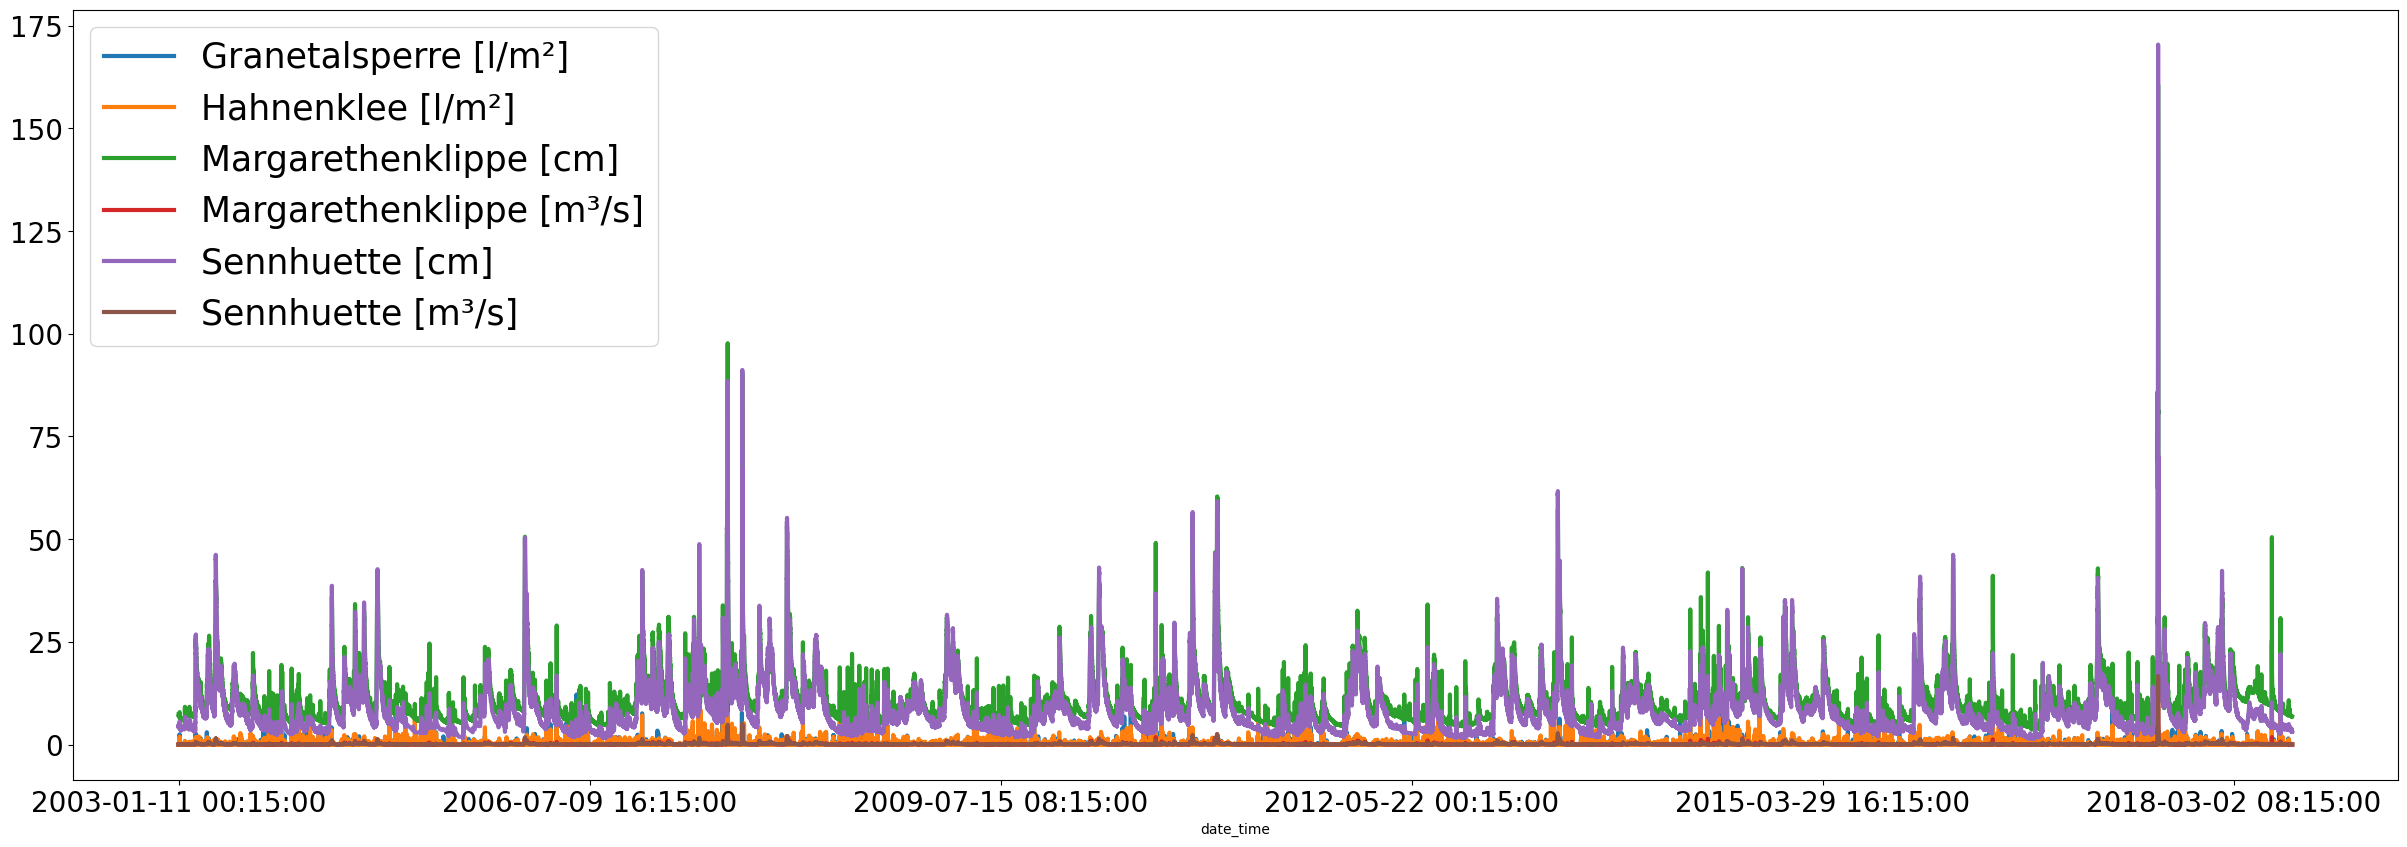

In [7]:

df.plot(figsize=(30,10), fontsize = 20, linewidth=3).legend(fontsize=25, loc="upper left")
plt.show()


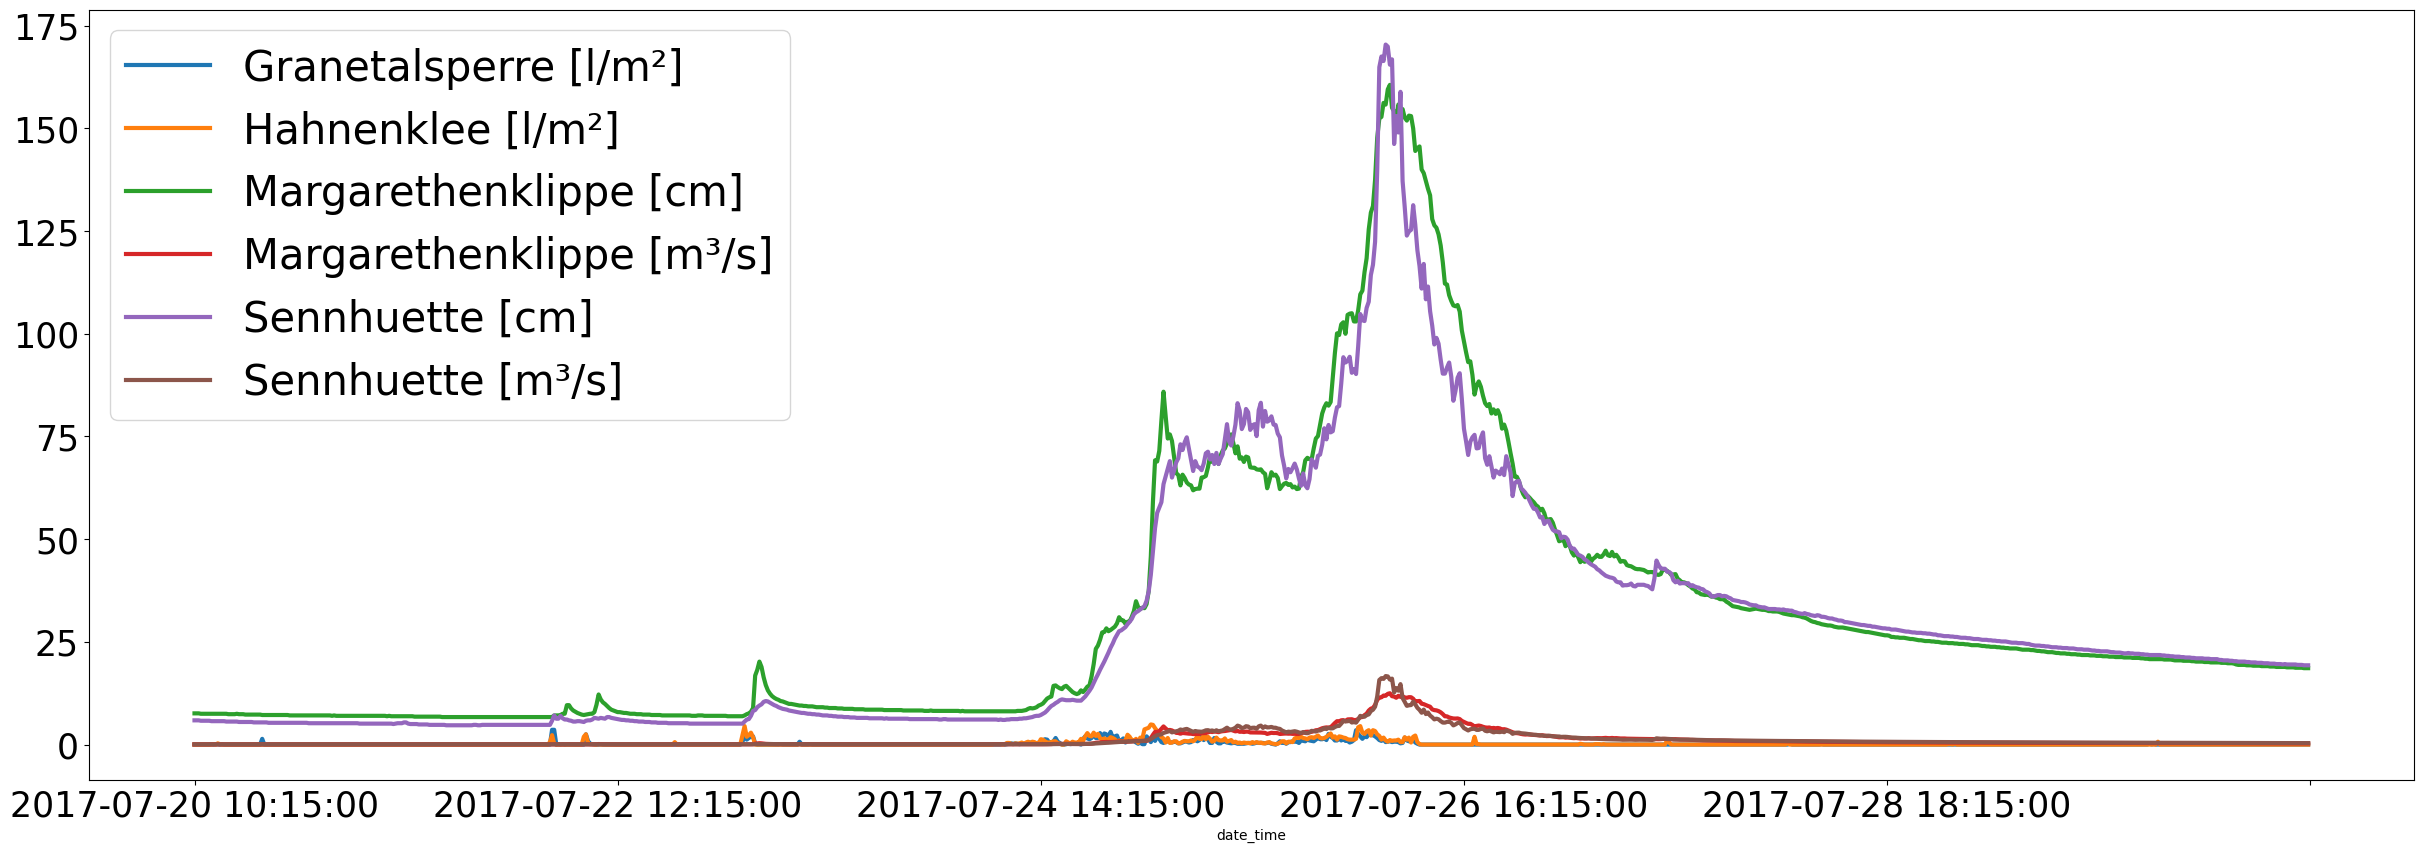

In [8]:

df[481000:482000].plot(figsize=(30,10), fontsize = 25, linewidth=3).legend(fontsize=30, loc="upper left")

plt.savefig("data during flood event 2017 .svg", format = 'svg', dpi=300)
plt.show()

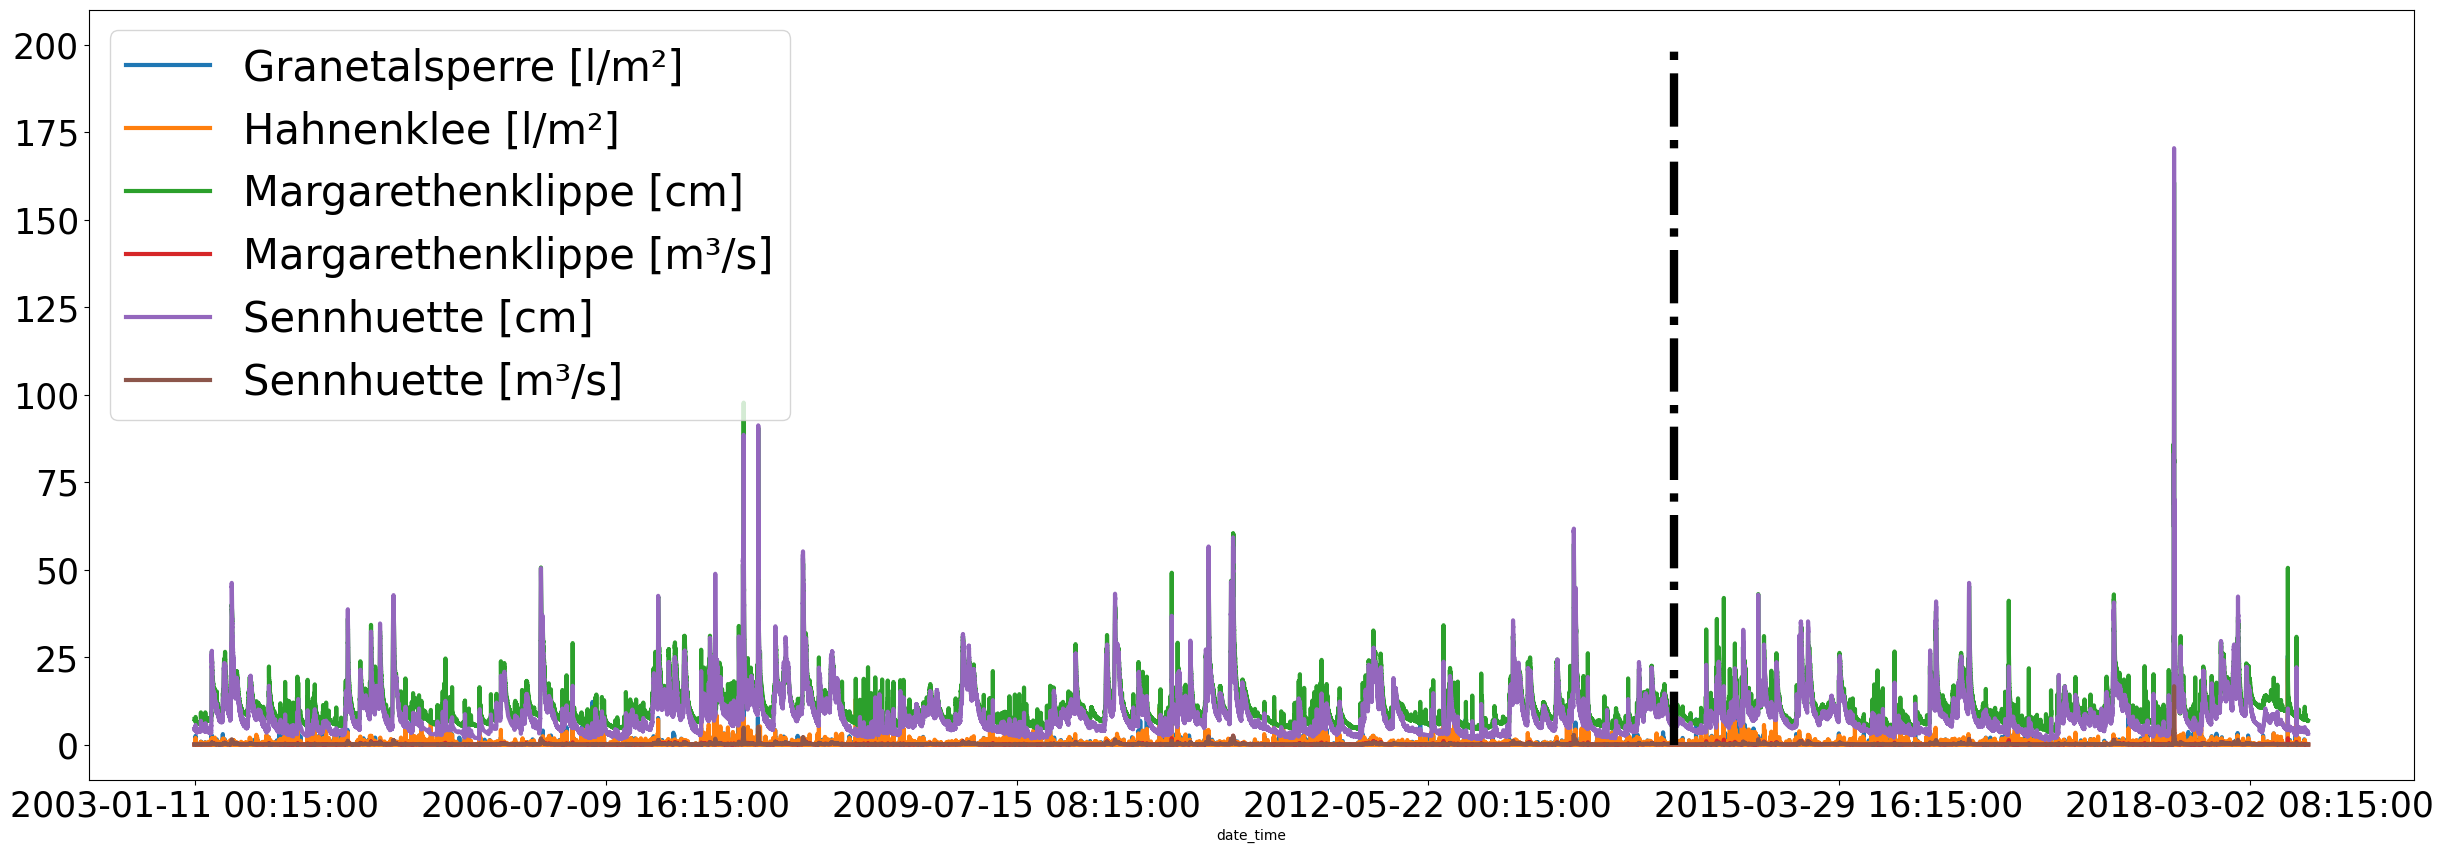

In [10]:

df.plot(figsize=(30,10), fontsize = 25, linewidth=3).legend(fontsize=30, loc="upper left")
plt.vlines(df.index.size*0.7, ymin=0, ymax=200, colors='black', linestyles='dashdot', label='',linewidth=6)
plt.savefig("train test split data.svg", format = 'svg', dpi=300)
plt.show()



In [10]:
df.index.size

514176

In [13]:
df_2_h_origin = pd.read_csv("framework/result_folder/result_2h.csv", delimiter=";", engine='python', index_col=0)
df_3_h_origin = pd.read_csv("framework/result_folder/result_3h.csv", delimiter=";", engine='python', index_col=0)
df_4_h_origin = pd.read_csv("framework/result_folder/result_4h.csv", delimiter=";", engine='python', index_col=0)

In [14]:
df_2_h_origin_old = pd.read_csv("framework/result_folder/simple_LSTM_architecture/result_2h.csv", delimiter=";", engine="python", index_col=0)
df_3_h_origin_old = pd.read_csv("framework/result_folder/simple_LSTM_architecture/result_3h.csv", delimiter=";", engine="python", index_col=0)
df_4_h_origin_old = pd.read_csv("framework/result_folder/simple_LSTM_architecture/result_4h.csv", delimiter=";", engine="python", index_col=0)



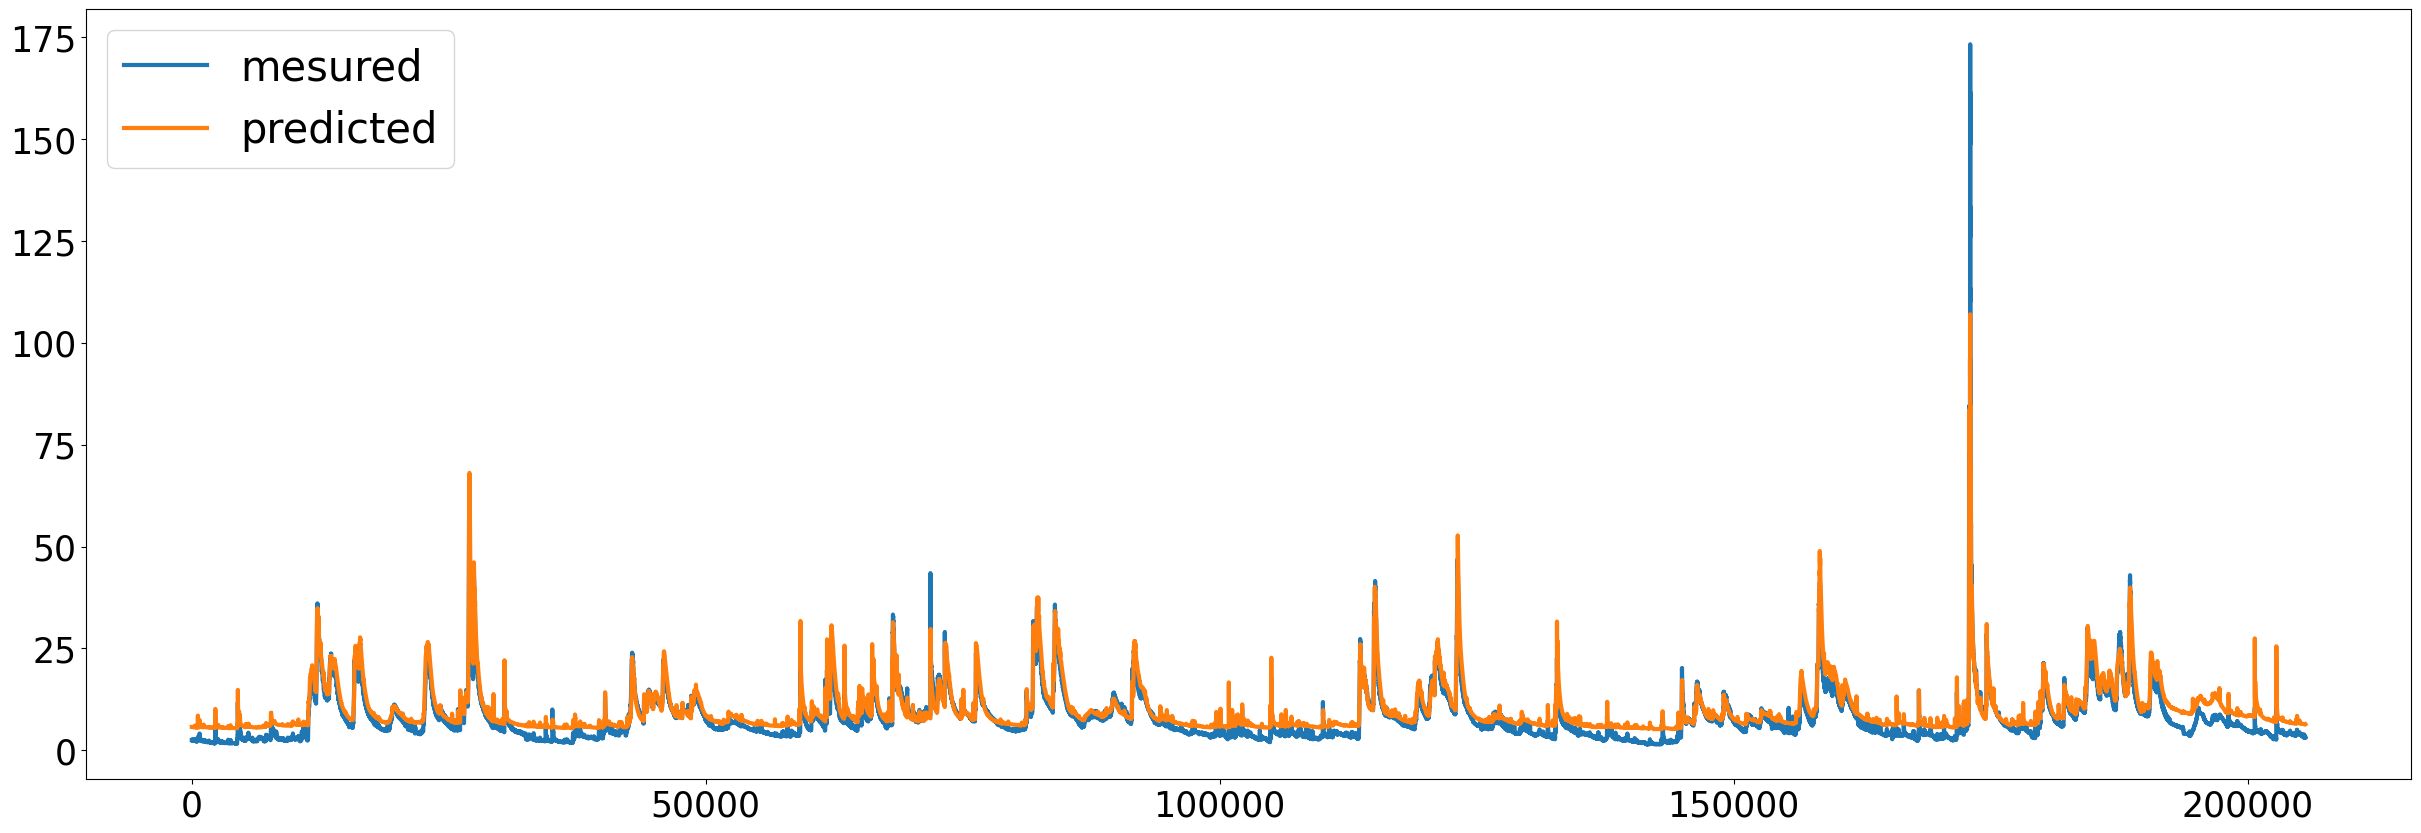

In [18]:
df_2_h_origin_old.plot(figsize=(30,10), fontsize = 25, linewidth=3).legend(fontsize=30, loc="upper left")

In [20]:
df_2_h_origin.plot(figsize=(30,10), fontsize = 25, linewidth=3).legend(fontsize=30, loc="upper left")

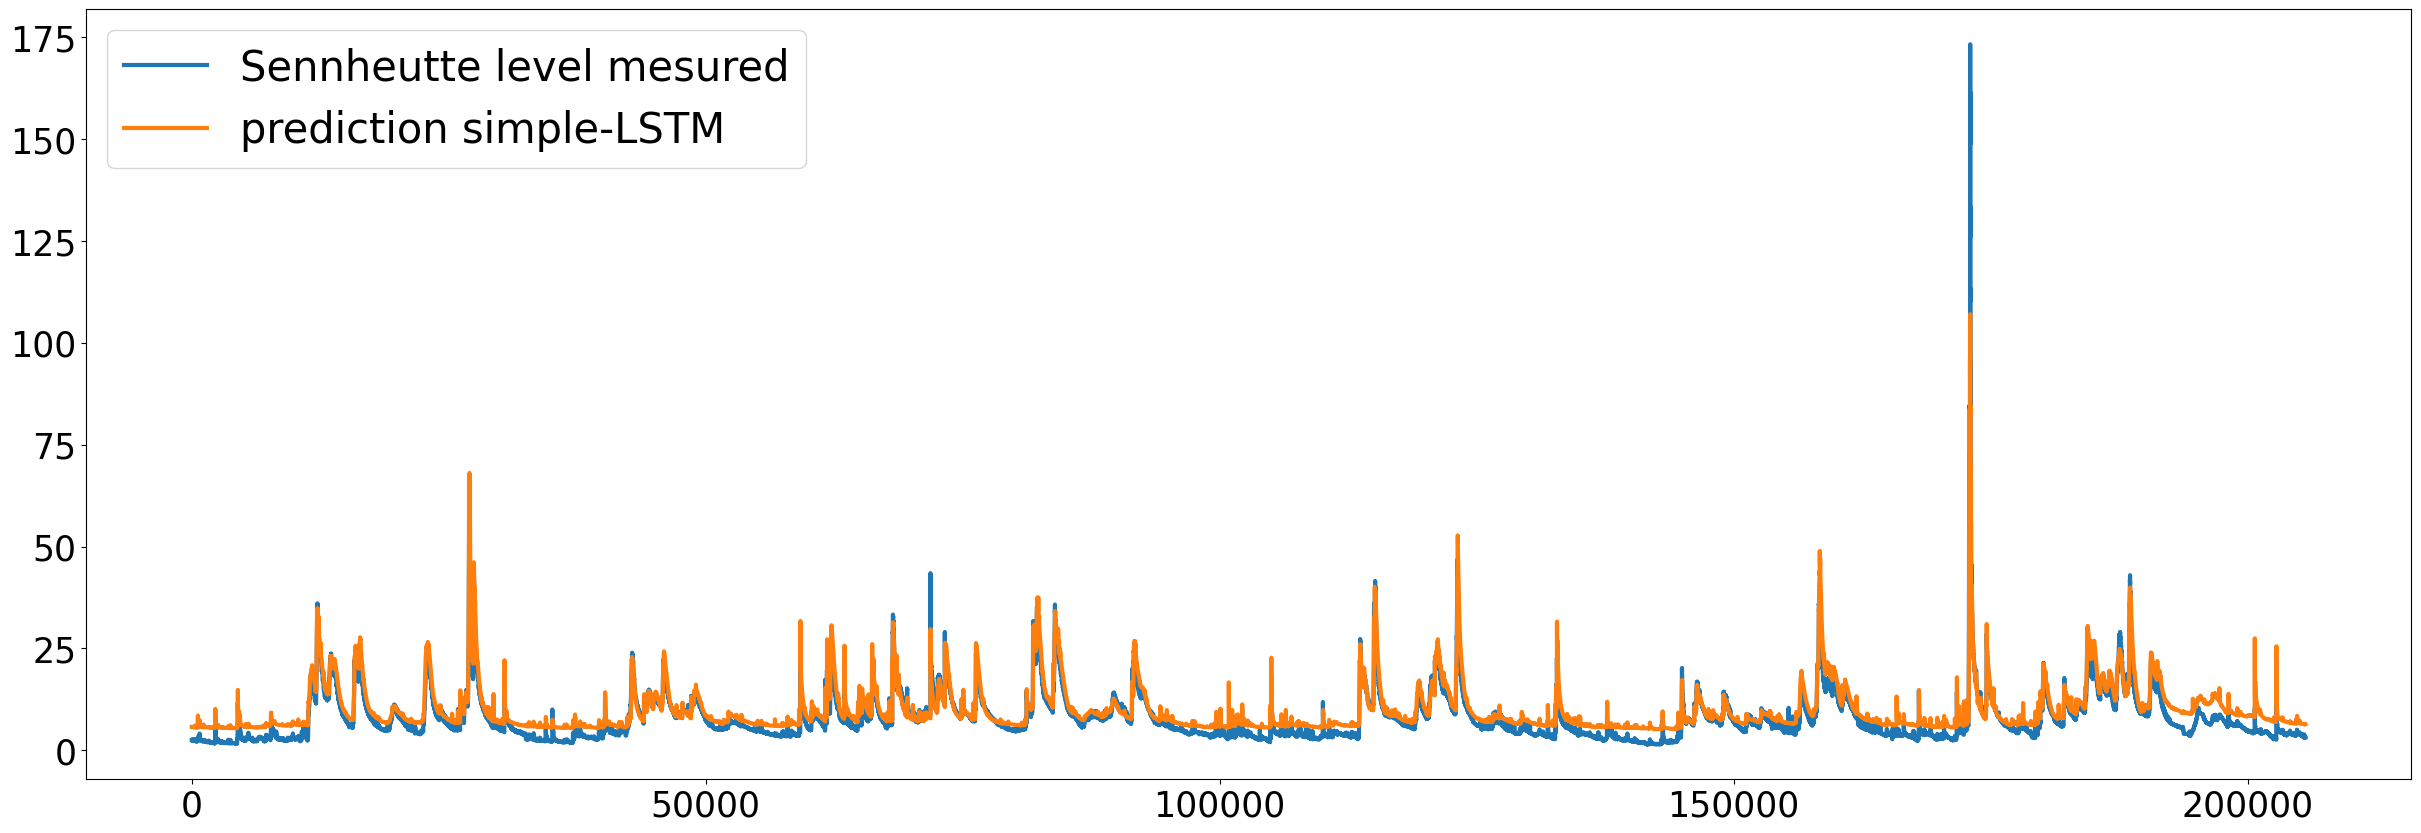

In [39]:
df_2h_comparison = pd.DataFrame()
df_2h_comparison["Sennheutte level mesured"] = df_2_h_origin_old["mesured"]
df_2h_comparison["prediction simple-LSTM"] = df_2_h_origin_old["predicted"]


#df_2h_comparison["prediction residual-LSTM"] = df_2_h_origin["predicted"]
df_2h_comparison.plot(figsize=(30,10), fontsize = 25, linewidth=3).legend(fontsize=30, loc="upper left")
plt.savefig("overall performance simple lstm.svg", format = 'svg', dpi=300)

In [41]:
df_2h_comparison = pd.DataFrame()
df_2h_comparison["Sennheutte level mesured"] = df_2_h_origin_old["mesured"]
df_2h_comparison["prediction simple-LSTM"] = df_2_h_origin_old["predicted"]


#df_2h_comparison["prediction residual-LSTM"] = df_2_h_origin["predicted"]
df_2h_comparison[172500:174000].plot(figsize=(30,10), fontsize = 25, linewidth=3).legend(fontsize=30, loc="upper left")
plt.savefig("event performance simple lstm.svg", format = 'svg', dpi=300)

In [42]:
df_2h_comparison = pd.DataFrame()
df_2h_comparison["Sennheutte level mesured"] = df_2_h_origin_old["mesured"]
#df_2h_comparison["prediction simple-LSTM"] = df_2_h_origin_old["predicted"]


df_2h_comparison["prediction residual-LSTM"] = df_2_h_origin["predicted"]
df_2h_comparison.plot(figsize=(30,10), fontsize = 25, linewidth=3).legend(fontsize=30, loc="upper left")
plt.savefig("overall performance residual lstm.svg", format = 'svg', dpi=300)

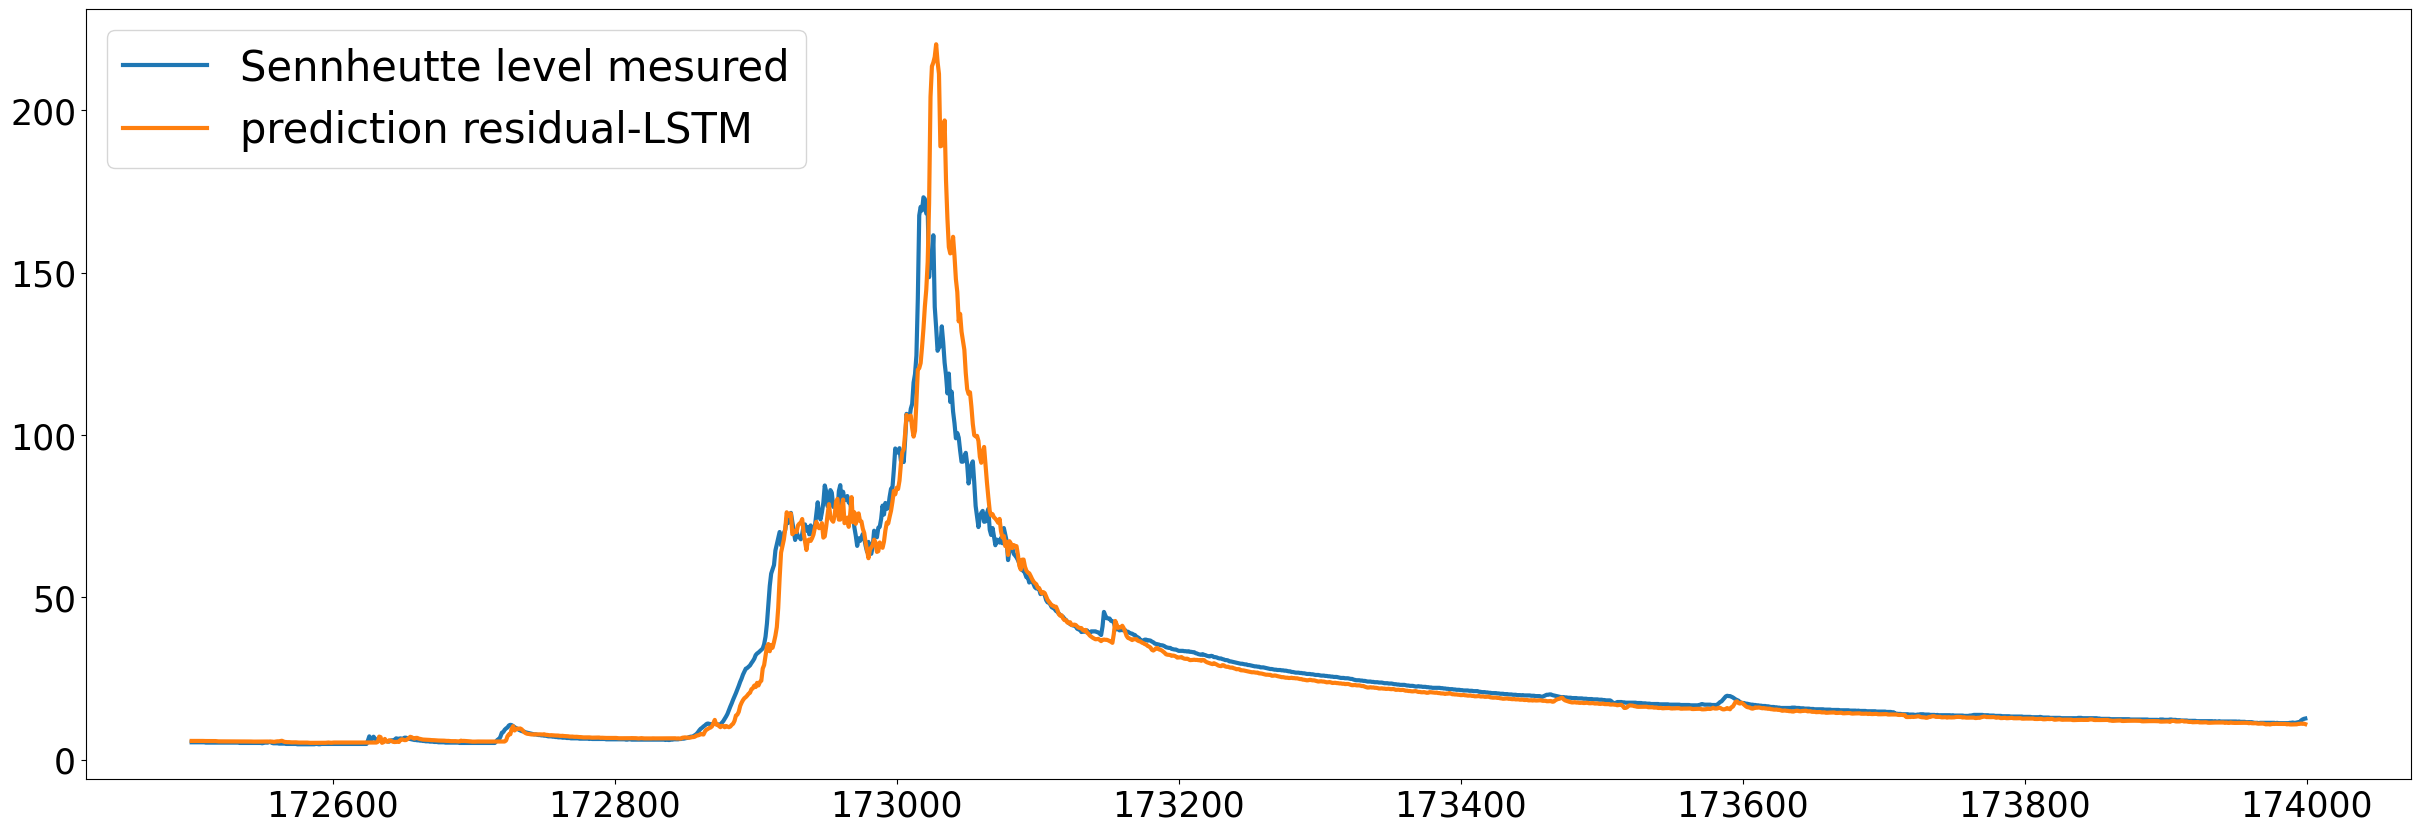

In [43]:
df_2h_comparison = pd.DataFrame()
df_2h_comparison["Sennheutte level mesured"] = df_2_h_origin_old["mesured"]
#df_2h_comparison["prediction simple-LSTM"] = df_2_h_origin_old["predicted"]


df_2h_comparison["prediction residual-LSTM"] = df_2_h_origin["predicted"]
df_2h_comparison[172500:174000].plot(figsize=(30,10), fontsize = 25, linewidth=3).legend(fontsize=30, loc="upper left")
plt.savefig("event performance residual lstm.svg", format = 'svg', dpi=300)